In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:2


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# %cd '/content/gdrive/MyDrive/Virginia Tech /Fall 2022/Codes from GPU/PINN_Stan/1D FODE/stan'

In [4]:
# !pip install smt

In [5]:
# lr_tune = np.array([0.05,0.1,0.25,0.5,1])

In [6]:
def true_1D_2(x): #True function for 1D_1 dy/dx = cos(0.01*x) BC1: y(0)=0; x \in [-100,100]
    y = extent*np.sin(x)/2 + np.square(x)/2
    return y
    

In [7]:
level = "high"
label = "1D_FODE_stan_" + level
extent = 100.0 #The domain/support is between -extent to +extent

loss_thresh = 0.005

x = np.linspace(extent,-1.0*extent,5000).reshape(-1,1)
ysol = true_1D_2(x)

bc1_x = np.array(0).reshape(-1,1) 
bc1_y = np.array(0).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y_bc1_train = torch.from_numpy(bc1_y).float().to(device)

 
x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)

y_true = true_1D_2(x_test)
y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

#torch.autograd.set_detect_anomaly(True)

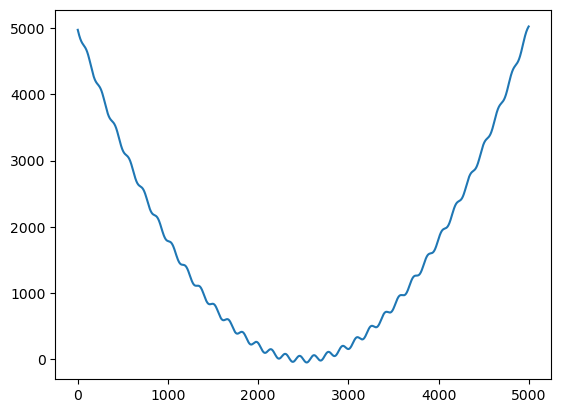

In [8]:
plt.plot(y_true)

In [9]:
def colloc_pts(N_f,seed):

  #Collocation Points
  # Latin Hypercube sampling for collocation points 
  # N_f sets of tuples(x,y)
  x01 = np.array([[0.0, 1.0]])
  sampling = LHS(xlimits=x01,random_state =seed)

  x_coll_train = lb + (ub-lb)*sampling(N_f)
  x_coll_train = np.vstack((x_coll_train, bc1_x)) # append training points to collocation points 

  return x_coll_train

In [10]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.iter = 0
        
              
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        f = dy_dx - extent*torch.cos(g)/2.0 -g 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_f
        
        return loss_val
     
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred

    def test_loss(self):
        y_pred = self.test()
        
       
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
      
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re 

In [11]:
def train_step(seed):
    x_coll_np_array = colloc_pts(N_f,seed*123)
    x_coll_train = torch.from_numpy(x_coll_np_array).float().to(device)        
    
    f_hat = torch.zeros(x_coll_train.shape[0],1).to(device)
    
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(x_bc1_train,y_bc1_train,x_coll_train,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        
        return loss

    optimizer.step(closure)

In [12]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [13]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*11)
    start_time = time.time() 
    thresh_flag = 0

    x_coll = torch.from_numpy(colloc_pts(N_f,123)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_coll,f_hat).cpu().detach().numpy()
    data_update(loss_np)

    for i in range(max_iter):
        train_step(i)

        loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_coll,f_hat).cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])

    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [14]:
max_reps = 10
max_iter = 200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):   
  train_loss = []
  test_mse_loss = []
  test_re_loss = []   
  beta_val = []

  torch.manual_seed(reps*36)
  N_f = 10000 #Total number of collocation points

  layers = np.array([1,50,50,50,1]) #9 hidden layers
  PINN = Sequentialmodel(layers)

  PINN.to(device)

  'Neural Network Summary'
  print(PINN)

  params = list(PINN.parameters())

  optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.01, 
                            max_iter = 10, 
                            max_eval = 15, 
                            tolerance_grad = 1e-6, 
                            tolerance_change = 1e-6, 
                            history_size = 100, 
                            line_search_fn = 'strong_wolfe')



  train_model(max_iter,reps)


  torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
  train_loss_full.append(train_loss)
  test_mse_full.append(test_mse_loss)
  test_re_full.append(test_re_loss)
  beta_full.append(beta_val)


  print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 4575.6055 Test MSE 5002477.787752137 Test RE 0.9997223654898356
1 Train Loss 4567.502 Test MSE 4948827.535363594 Test RE 0.9943470352917565
2 Train Loss 4427.264 Test MSE 4606974.914367602 Test RE 0.9593890280300079
3 Train Loss 3086.7095 Test MSE 1576836.9947972102 Test RE 0.561280848558456
4 Train Loss 1917.0099 Test MSE 260234.9816933635 Test RE 0.2280182779332087
5 Train Loss 1692.2147 Test MSE 232397.0194574576 Test RE 0.21547758554364943
6 Train Loss 1555.5781 Test MSE 168569.85912997302 Test RE 0.18351720473486605
7 Train Loss 1507.9075 Test MSE 248629.94584196588 Test RE 0.22287612140038876
8 Train Loss 1473.5692 Test MSE 201898.99

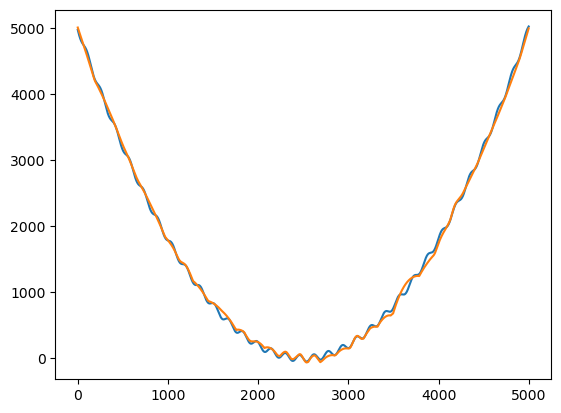

In [15]:
u_pred = PINN.test()
plt.plot(y_true)
plt.plot(u_pred)

In [16]:
import scipy.io as sio

In [17]:
for tune_reps in range(5):
    label = "1D_FODE_stan_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re_loss"])
    print(np.mean(re[:,-1]))

FileNotFoundError: [Errno 2] No such file or directory: '1D_FODE_stan_tune0.mat'